In [33]:
import pandas as pd
import sys
import numpy as np
from pandas import DataFrame
from sklearn.model_selection import train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

from scipy.stats.stats import pearsonr
from math import sqrt
import statistics 
from scipy.stats import *
from scipy.spatial import distance

############################################################
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from matplotlib.colors import ListedColormap
from matplotlib import cm
import geopandas as gpd

print("Repositories uploaded!!")

Repositories uploaded!!


In [ ]:
###################### Creating the GRID dataset ######################

In [ ]:
### cmaq_id is to be removed.
### day can be left out.

In [74]:
#### import small training dataset
df_pm25small = pd.read_csv("US_data/BigUS/pm25small_lut.csv", index_col=None)
df_pm25small = df_pm25small.drop(['Unnamed: 0'], axis = 1)

<ipython-input-74-dfd3f0f990a3>:2: DtypeWarning: Columns (91,94,118) have mixed types. Specify dtype option on import or set low_memory=False.
  df_pm25small = pd.read_csv("US_data/BigUS/pm25small_lut.csv", index_col=None)


In [75]:
##### replacing NaN values with mean values
mean_value = df_pm25small['elev'].mean()
df_pm25small['elev'].fillna(value = mean_value, inplace=True)

mean_value = df_pm25small['forest_cover'].mean()
df_pm25small['forest_cover'].fillna(value = mean_value, inplace=True)

mean_value = df_pm25small['is'].mean()
df_pm25small['is'].fillna(value = mean_value, inplace=True)

In [76]:
### split into features to be standardized and the ones not to be standardizes.

df_pm25_noscale = df_pm25small[['day', 'pm_x', 'pm_y', 'cmaq_id', 'pm25_value']]
df_pm25_scale = df_pm25small[['elev', 'forest_cover', 'pd', 'local', 'limi', 'high', 'is', 'nldas_pevapsfc', 'nldas_pressfc', 'nldas_cape',
                            'nldas_ugrd10m', 'nldas_vgrd10m', 'nldas_tmp2m', 'nldas_rh2m', 'nldas_dlwrfsfc', 'nldas_dswrfsfc', 'nldas_pcpsfc', 'nldas_fpcsfc',
                            'aod_value', 'emissi11_pm25']]

In [77]:
### Run the standard scaler.

from sklearn.preprocessing import StandardScaler

scale_cols = ['elev', 'forest_cover', 'pd', 'local', 'limi', 'high', 'is', 'nldas_pevapsfc', 'nldas_pressfc', 'nldas_cape',
                            'nldas_ugrd10m', 'nldas_vgrd10m', 'nldas_tmp2m', 'nldas_rh2m', 'nldas_dlwrfsfc', 'nldas_dswrfsfc', 'nldas_pcpsfc', 'nldas_fpcsfc',
                            'aod_value', 'emissi11_pm25']
ss = StandardScaler()
df_pm25_scale[scale_cols] = ss.fit_transform(df_pm25_scale[scale_cols])

<ipython-input-77-4815c174be26>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pm25_scale[scale_cols] = ss.fit_transform(df_pm25_scale[scale_cols])


In [78]:
### concatenate the 'standardized + non-standardized'

df_small_fs = pd.concat([df_pm25_scale, df_pm25_noscale], axis=1)
df_small_fs = df_small_fs.reset_index(drop = True)

In [199]:
### concatenate the 'standardized + non-standardized' -- remove id and location,time features

df_small_nid = pd.concat([df_pm25_scale, df_pm25_noscale['pm25_value']], axis=1)
df_small_nid = df_small_nid.reset_index(drop = True)

In [ ]:
### run prediction model on smaller dataset -- RF

In [79]:
### removing outliers
df_small_fs = df_small_fs[df_small_fs.pm25_value < 40]
df_small_fs = df_small_fs.reset_index(drop = True)

In [80]:
df_small_fs

,elev,forest_cover,pd,local,limi,high,is,nldas_pevapsfc,nldas_pressfc,nldas_cape,...,nldas_dswrfsfc,nldas_pcpsfc,nldas_fpcsfc,aod_value,emissi11_pm25,day,pm_x,pm_y,cmaq_id,pm25_value
0,-0.103999,-0.585101,0.493962,-0.216977,-0.351019,-0.460546,1.073763,-1.613532,0.281213,-0.378959,...,-1.445129,-0.094654,-0.180297,0.330120,-0.058709,4,-1.482817e+06,1.283559e+06,55167,13.2
1,-0.103999,-0.585101,0.493962,-0.216977,-0.351019,-0.460546,1.073763,-1.583365,0.309005,-0.378959,...,-1.438081,-0.094654,-0.180297,-0.548720,-0.058709,5,-1.482817e+06,1.283559e+06,55167,18.1
2,-0.103999,-0.585101,0.493962,-0.216977,-0.351019,-0.460546,1.073763,-1.528579,0.173102,-0.378959,...,-1.391815,-0.094654,-0.180297,-0.094056,-0.058709,7,-1.482817e+06,1.283559e+06,55167,20.3
3,-0.103999,-0.585101,0.493962,-0.216977,-0.351019,-0.460546,1.073763,-1.492576,0.090508,-0.378959,...,-1.409396,-0.094654,-0.180297,0.024137,-0.058709,8,-1.482817e+06,1.283559e+06,55167,22.6
4,-0.103999,-0.585101,0.493962,-0.216977,-0.351019,-0.460546,1.073763,-1.609856,0.207823,-0.378959,...,-1.416048,-0.094654,-0.180297,0.157799,-0.058709,10,-1.482817e+06,1.283559e+06,55167,17.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80070,-0.669105,0.162381,-0.308963,-0.960418,-0.351019,-0.460546,-0.173255,-1.963143,1.064133,-0.378959,...,-2.457914,-0.094654,-0.180297,-0.670670,-0.058709,350,-2.245780e+06,2.601795e+06,103055,5.8
80071,-0.669105,0.162381,-0.308963,-0.960418,-0.351019,-0.460546,-0.173255,-1.886009,0.906985,-0.378959,...,-2.414124,-0.094654,-0.180297,-0.646373,-0.058709,351,-2.245780e+06,2.601795e+06,103055,7.9
80072,-0.669105,0.162381,-0.308963,-0.960418,-0.351019,-0.460546,-0.173255,-1.781162,1.012660,-0.378959,...,-2.435467,-0.094654,-0.180297,-0.312772,-0.058709,356,-2.245780e+06,2.601795e+06,103055,5.7
80073,-0.669105,0.162381,-0.308963,-0.960418,-0.351019,-0.460546,-0.173255,-1.902227,1.098145,-0.378959,...,-2.501039,-0.094654,-0.180297,-0.591137,-0.058709,358,-2.245780e+06,2.601795e+06,103055,7.5


In [81]:
df_small_fs.isna().sum()

elev              0
forest_cover      0
pd                0
local             0
limi              0
high              0
is                0
nldas_pevapsfc    0
nldas_pressfc     0
nldas_cape        0
nldas_ugrd10m     0
nldas_vgrd10m     0
nldas_tmp2m       0
nldas_rh2m        0
nldas_dlwrfsfc    0
nldas_dswrfsfc    0
nldas_pcpsfc      0
nldas_fpcsfc      0
aod_value         0
emissi11_pm25     0
day               0
pm_x              0
pm_y              0
cmaq_id           0
pm25_value        0
dtype: int64

In [175]:
#### Checking the spread of NaN values
df_small_nan = df_small_fs[df_small_fs.isna().any(axis=1)]
df_small_nan

,elev,forest_cover,pd,local,limi,high,is,nldas_pevapsfc,nldas_pressfc,nldas_cape,...,nldas_dswrfsfc,nldas_pcpsfc,nldas_fpcsfc,aod_value,emissi11_pm25,day,pm_x,pm_y,cmaq_id,pm25_value


In [ ]:
### Validate their summary statistics with the paper.
### Check if the small nan values are randomly located in the dataset
### interpolation technique for filling in gc_aod value -- kriging interpolation, inverse distance weighting (IDW)

In [176]:
######### For Day == 1 #########

df_small_fs_1 = df_small_fs[df_small_fs['day'] == 1]
df_small_fs_1 = df_small_fs_1.reset_index(drop = True)
# df_pm25small_1[['year', 'day', 'cmaq_id', 'cmaq_x', 'cmaq_y', 'pm_id']]
df_small_fs_1.shape

(46, 25)

In [ ]:
################################ For all features ################################

In [58]:
from sklearn.model_selection import train_test_split

df_small_train, df_small_test = train_test_split(df_small_fs, test_size=0.2)

df_small_train_y = df_small_train['pm25_value'] 
df_small_train_X = df_small_train.drop(['pm25_value'], axis = 1)
df_small_test_y = df_small_test['pm25_value'] 
df_small_test_X = df_small_test.drop(['pm25_value'], axis = 1)

In [193]:
### Trying to run on ML algorithms ###
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


RF = RandomForestRegressor(n_estimators=1000, max_depth=6)
RF.fit(df_small_train_X, df_small_train_y)
RF_pred = RF.predict(df_small_test_X)

mse_RF = sqrt(mean_squared_error(df_small_test_y, RF_pred))
r2_RF = pearsonr(df_small_test_y, RF_pred)
r2_RF = (r2_RF[0])**2
print(mse_RF, r2_RF)

XGB = XGBRegressor(n_estimators=1000, max_depth=6,learning_rate = 0.1) #eta=0.1)
XGB.fit(df_small_train_X, df_small_train_y)
XGB_pred = XGB.predict(df_small_test_X)

mse_XGB = sqrt(mean_squared_error(df_small_test_y, XGB_pred))
r2_XGB = pearsonr(df_small_test_y, XGB_pred)
r2_XGB = (r2_XGB[0])**2
print(mse_XGB, r2_XGB)

GBR = GradientBoostingRegressor(n_estimators = 1000, max_depth=6, learning_rate = 0.1)
GBR.fit(df_small_train_X, df_small_train_y)
GBR_pred = GBR.predict(df_small_test_X)

mse_GBR = sqrt(mean_squared_error(df_small_test_y, GBR_pred))
r2_GBR = pearsonr(df_small_test_y, GBR_pred)
r2_GBR = (r2_GBR[0])**2
print(mse_GBR, r2_GBR)


4.97644633884594 0.4133216480836687
3.381477569106016 0.7266234714413612
3.412780843872505 0.7209814069653877


In [ ]:
################################ Removed ID, Location, Time features ################################

In [201]:
from sklearn.model_selection import train_test_split

df_small_train, df_small_test = train_test_split(df_small_nid, test_size=0.2)

df_small_train_y = df_small_train['pm25_value'] 
df_small_train_X = df_small_train.drop(['pm25_value'], axis = 1)
df_small_test_y = df_small_test['pm25_value'] 
df_small_test_X = df_small_test.drop(['pm25_value'], axis = 1)

In [202]:
df_small_train_X.shape

(64274, 20)

In [203]:
### Trying to run on ML algorithms ###
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


RF = RandomForestRegressor(n_estimators=1000, max_depth=6)
RF.fit(df_small_train_X, df_small_train_y)
RF_pred = RF.predict(df_small_test_X)

mse_RF = sqrt(mean_squared_error(df_small_test_y, RF_pred))
r2_RF = pearsonr(df_small_test_y, RF_pred)
r2_RF = (r2_RF[0])**2
print(mse_RF, r2_RF)

XGB = XGBRegressor(n_estimators=1000, max_depth=6,learning_rate = 0.1) #eta=0.1)
XGB.fit(df_small_train_X, df_small_train_y)
XGB_pred = XGB.predict(df_small_test_X)

mse_XGB = sqrt(mean_squared_error(df_small_test_y, XGB_pred))
r2_XGB = pearsonr(df_small_test_y, XGB_pred)
r2_XGB = (r2_XGB[0])**2
print(mse_XGB, r2_XGB)

GBR = GradientBoostingRegressor(n_estimators = 1000, max_depth=6, learning_rate = 0.1)
GBR.fit(df_small_train_X, df_small_train_y)
GBR_pred = GBR.predict(df_small_test_X)

mse_GBR = sqrt(mean_squared_error(df_small_test_y, GBR_pred))
r2_GBR = pearsonr(df_small_test_y, GBR_pred)
r2_GBR = (r2_GBR[0])**2
print(mse_GBR, r2_GBR)


5.024921942062186 0.3724241115657916
3.6796856781563605 0.6616224033214968
3.697257759480659 0.6582718271269475


In [59]:
######### import big US datasets for 12 months #########

df_BUS_1 = pd.read_csv("US_data/BigUS/n_aod_pred_2011_new10_1.csv")
df_BUS_2 = pd.read_csv("US_data/BigUS/n_aod_pred_2011_new10_2.csv")
df_BUS_3 = pd.read_csv("US_data/BigUS/n_aod_pred_2011_new10_3.csv")
df_BUS_4 = pd.read_csv("US_data/BigUS/n_aod_pred_2011_new10_4.csv")
df_BUS_5 = pd.read_csv("US_data/BigUS/n_aod_pred_2011_new10_5.csv")
df_BUS_6 = pd.read_csv("US_data/BigUS/n_aod_pred_2011_new10_6.csv")
df_BUS_7 = pd.read_csv("US_data/BigUS/n_aod_pred_2011_new10_7.csv")
df_BUS_8 = pd.read_csv("US_data/BigUS/n_aod_pred_2011_new10_8.csv")
df_BUS_9 = pd.read_csv("US_data/BigUS/n_aod_pred_2011_new10_9.csv")
df_BUS_10 = pd.read_csv("US_data/BigUS/n_aod_pred_2011_new10_10.csv")
df_BUS_11 = pd.read_csv("US_data/BigUS/n_aod_pred_2011_new10_11.csv")
df_BUS_12 = pd.read_csv("US_data/BigUS/n_aod_pred_2011_new10_12.csv")

In [60]:
df_BUS = pd.concat([df_BUS_1, df_BUS_2, df_BUS_3, df_BUS_4, df_BUS_5, df_BUS_6, df_BUS_7, df_BUS_8, df_BUS_9, df_BUS_10, df_BUS_11, df_BUS_12], ignore_index = True)

In [61]:
df_BUS.shape

(19639555, 77)

In [62]:
df_BUS.columns

Index(['year', 'day', 'cmaq_x', 'cmaq_y', 'elev', 'emissi11_pm25',
       'forest_cover', 'high', 'limi', 'local', 'is', 'pd', 'lon', 'lat',
       'rid', 'elev_k', 'emissi11_pm25_k', 'emissi11_pm10_k', 'forest_cover_k',
       'high_k', 'limi_k', 'local_k', 'is_k', 'pd_k', 'cmaq_id',
       'nldas_pevapsfc', 'nldas_dlwrfsfc', 'nldas_dswrfsfc', 'nldas_cape',
       'nldas_fpcsfc', 'nldas_pcpsfc', 'nldas_rh2m', 'nldas_tmp2m',
       'nldas_vgrd10m', 'nldas_ugrd10m', 'nldas_pressfc', 'narr_dpt',
       'narr_vis', 'narr_hpbl', 'narr_rh2m', 'narr_tmp2m', 'narr_ugrd10m',
       'narr_vgrd10m', 'narr_rh30mb', 'narr_rh63mb', 'narr_rh96mb',
       'narr_rh129mb', 'narr_rh1512mb', 'narr_rh1815mb', 'narr_tmp30mb',
       'narr_tmp63mb', 'narr_tmp96mb', 'narr_tmp129mb', 'narr_tmp1512mb',
       'narr_tmp1815mb', 'narr_ugrd30m', 'narr_ugrd30mb', 'narr_ugrd63mb',
       'narr_ugrd96mb', 'narr_ugrd129mb', 'narr_ugrd1512mb', 'narr_ugrd1815mb',
       'narr_vgrd30m', 'narr_vgrd30mb', 'narr_vgrd63mb',

In [63]:
## replace NaN 'aod_value' slots with values in 'gc_aod'
df_BUS.aod_value.fillna(df_BUS.gc_aod, inplace=True)
df_BUS['aod_value'].isna().sum()

0

In [64]:
##### replacing NaN values with mean values
mean_value = df_BUS['nldas_pevapsfc'].mean()
df_BUS['nldas_pevapsfc'].fillna(value = mean_value, inplace=True)

mean_value = df_BUS['nldas_pressfc'].mean()
df_BUS['nldas_pressfc'].fillna(value = mean_value, inplace=True)

mean_value = df_BUS['nldas_cape'].mean()
df_BUS['nldas_cape'].fillna(value = mean_value, inplace=True)

mean_value = df_BUS['nldas_ugrd10m'].mean()
df_BUS['nldas_ugrd10m'].fillna(value = mean_value, inplace=True)

mean_value = df_BUS['nldas_vgrd10m'].mean()
df_BUS['nldas_vgrd10m'].fillna(value = mean_value, inplace=True)

mean_value = df_BUS['nldas_tmp2m'].mean()
df_BUS['nldas_tmp2m'].fillna(value = mean_value, inplace=True)

mean_value = df_BUS['nldas_rh2m'].mean()
df_BUS['nldas_rh2m'].fillna(value = mean_value, inplace=True)

mean_value = df_BUS['nldas_dlwrfsfc'].mean()
df_BUS['nldas_dlwrfsfc'].fillna(value = mean_value, inplace=True)

mean_value = df_BUS['nldas_dswrfsfc'].mean()
df_BUS['nldas_dswrfsfc'].fillna(value = mean_value, inplace=True)

mean_value = df_BUS['nldas_pcpsfc'].mean()
df_BUS['nldas_pcpsfc'].fillna(value = mean_value, inplace=True)

mean_value = df_BUS['nldas_fpcsfc'].mean()
df_BUS['nldas_fpcsfc'].fillna(value = mean_value, inplace=True)

In [65]:
df_BUS[['aod_value', 'gc_aod']].isna().sum()

aod_value    0
gc_aod       0
dtype: int64

In [66]:
### split into features to be standardized and the ones not to be standardizes.
df_BUS_noscale = df_BUS[['day', 'cmaq_x', 'cmaq_y', 'cmaq_id', 'pm25_value']]
df_BUS_scale = df_BUS[['elev', 'forest_cover', 'pd', 'local', 'limi', 'high', 'is', 'nldas_pevapsfc', 'nldas_pressfc', 'nldas_cape',
                            'nldas_ugrd10m', 'nldas_vgrd10m', 'nldas_tmp2m', 'nldas_rh2m', 'nldas_dlwrfsfc', 'nldas_dswrfsfc', 'nldas_pcpsfc', 'nldas_fpcsfc',
                            'aod_value', 'emissi11_pm25']]

In [67]:
### Run the standard scaler.
from sklearn.preprocessing import StandardScaler

scale_cols = ['elev', 'forest_cover', 'pd', 'local', 'limi', 'high', 'is', 'nldas_pevapsfc', 'nldas_pressfc', 'nldas_cape',
                            'nldas_ugrd10m', 'nldas_vgrd10m', 'nldas_tmp2m', 'nldas_rh2m', 'nldas_dlwrfsfc', 'nldas_dswrfsfc', 'nldas_pcpsfc', 'nldas_fpcsfc',
                            'aod_value', 'emissi11_pm25']
ss = StandardScaler()
df_BUS_scale[scale_cols] = ss.fit_transform(df_BUS_scale[scale_cols])

<ipython-input-67-b830b58c37cf>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_BUS_scale[scale_cols] = ss.fit_transform(df_BUS_scale[scale_cols])


In [68]:
### concatenate the 'standardized + non-standardized'
df_BUS_fs = pd.concat([df_BUS_scale, df_BUS_noscale], axis=1)
df_BUS_fs = df_BUS_fs.reset_index(drop = True)

In [69]:
df_BUS_fs.shape

(19639555, 25)

In [70]:
df_BUS_fs.isna().sum()

elev                     0
forest_cover             0
pd                       0
local                    0
limi                     0
high                     0
is                       0
nldas_pevapsfc           0
nldas_pressfc            0
nldas_cape               0
nldas_ugrd10m            0
nldas_vgrd10m            0
nldas_tmp2m              0
nldas_rh2m               0
nldas_dlwrfsfc           0
nldas_dswrfsfc           0
nldas_pcpsfc             0
nldas_fpcsfc             0
aod_value                0
emissi11_pm25            0
day                      0
cmaq_x                   0
cmaq_y                   0
cmaq_id                  0
pm25_value        19390426
dtype: int64

In [92]:
######### For Day == 1 #########

df_BUS_fs_1 = df_BUS_fs[df_BUS_fs['day'] == 1]
df_BUS_fs_1 = df_BUS_fs_1.reset_index(drop = True)
df_BUS_fs_1.shape

(53807, 25)

In [ ]:
#### small dataset has NaN samples grouped together.
#### large dataset has NaN samples spread out.

In [71]:
######### import the rasterio file #########

import rasterio as rt

rast_us = rt.open('US_data/BigUS/test.tif')

In [72]:
rast_us_1 = rast_us.read(1)
rast_us_1[rast_us_1 == rast_us.nodata] = 0

In [15]:
### uncomment this when you want to print the entire numpy array
np.set_printoptions(threshold=sys.maxsize)

In [73]:
rast_us_1.shape ##numpy array where the missing values are nan

(228, 369)

In [237]:
testarr1 = np.array([[ 1,  2,  3],
                [ 4,  5,  6],
                [ 7,  8,  9]])
testarr2 = np.array([[ 10,  11,  12],
                [ 13,  14,  15],
                [ 16,  17,  18]])

testarr = np.dstack((testarr1, testarr2))
print(testarr.shape)
testarr = testarr.reshape(-1,2, order='F')
print('---------------------')
print(testarr)

(3, 3, 2)
---------------------
[[ 1 10]
 [ 4 13]
 [ 7 16]
 [ 2 11]
 [ 5 14]
 [ 8 17]
 [ 3 12]
 [ 6 15]
 [ 9 18]]


In [277]:
testarr1 = np.array([[ 1,  2,  3],
                [ 4,  5,  6],
                [ 7,  8,  9]])
testarr2 = np.array([[ 10,  11,  12],
                [ 13,  14,  15],
                [ 16,  17,  18]])

testarr3 = np.array([[ 19,  20,  21],
                [ 22,  23,  24],
                [ 25,  26,  27]])


dictarr = {}

dictarr[1] = testarr1
dictarr[1]

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [ ]:
# elev, forest_cover, pd, local, limi, high, is, nldas_pevapsfc, nldas_pressfc, nldas_cape, nldas_ugrd10m, nldas_vgrd10m, nldas_tmp2m, nldas_rh2m, 
# nldas_dlwrfsfc, nldas_dswrfsfc, nldas_pcpsfc, nldas_fpcsfc, aod_value, emissi11_pm25


In [ ]:
#### Should I use np.stack to form a numpy array that looks like 5x5x21 but has a shape 21x5x5, 
#### whereas np.dstack makes a shape 5x5x21 but looks different (like an upward view of the cube)

In [82]:
N = 5
N_ = int(N/2)

key = 0
targetlist = []
traininglist = []
training_difflist = []

# fgrid = open('US_data/BigUS/grid3d.npy', 'ab+')

for day in range(1,366):
    print(day)
    df_BUS_fs_1 = df_BUS_fs[df_BUS_fs['day'] == day]
    df_BUS_fs_1 = df_BUS_fs_1.reset_index(drop = True)
    
    df_small_fs_1 = df_small_fs[df_small_fs['day'] == day]
    df_small_fs_1 = df_small_fs_1.reset_index(drop = True)
    
    for idx, rowval in df_small_fs_1.iterrows(): ### iterate over each row
        featarr = np.ones((5, 5))
        feat_diffdict = {}
        idx_ = 0
        for colname in df_small_fs_1: ###iterate over every column
#             print(colname)
            
            if colname == 'cmaq_id' or colname == 'pm_x' or colname == 'pm_y' or colname == 'day':
                continue
            elif colname == 'pm25_value':
                targetval = rowval['pm25_value']
            else:
                idx_ = idx_ + 1
                temparr = np.ones((5, 5))
                cmaqval = rowval['cmaq_id']
                row, col = np.where(rast_us_1 == cmaqval)
                cmaqgrid = np.array(rast_us_1[row[0] - N_:row[0]+(N_+1), col[0]- N_:col[0]+(N_+1)])
                
                if cmaqgrid.shape[0] == 5 and cmaqgrid.shape[1] == 5:
#                     print(cmaqgrid.shape)
                    for i in range(5): ## Add values element-wise 
                        for j in range(5):
                            if i == 2 and j == 2: ##where the hell are you putting these values? Like when?
#                                 continue
#                                 print(rowval[colname])
                                temparr[i,j] = rowval[colname]                               
    
                            else:
                                match_cmaq = cmaqgrid[i,j]
                                if match_cmaq == 0: ## compare this to 0 || previously: if np.isnan(match_cmaq): 
                                    temparr[i,j] = match_cmaq
                                    
                                else:
                                    locval_df = df_BUS_fs_1[df_BUS_fs_1['cmaq_id'] == match_cmaq]
                                    locval = locval_df[colname]
                                    temparr[i,j] = locval
                                    
                else:
                    continue
                
                    
                
            featarr = np.dstack((featarr,temparr))
            feat_diffdict[idx_] = temparr 
        
        if featarr.shape[0] == 5 and featarr.shape[1] == 5 and featarr.shape[2] == 22:
#             print(featarr.shape)
            featarr = np.delete(featarr, (0), axis = 2) ##delete first
            featarr = np.delete(featarr, (20), axis = 2) ##delete 20th which is extra
            
            targetlist.append(targetval)
            
#             print("Counter value is:", idx_)
            feat_diffarr = np.stack((feat_diffdict[1], feat_diffdict[2], feat_diffdict[3], feat_diffdict[4], feat_diffdict[5], 
                                     feat_diffdict[6], feat_diffdict[7], feat_diffdict[8], feat_diffdict[9], feat_diffdict[10], 
                                     feat_diffdict[11], feat_diffdict[12], feat_diffdict[13], feat_diffdict[14], feat_diffdict[15], 
                                     feat_diffdict[16], feat_diffdict[17], feat_diffdict[18], feat_diffdict[19], feat_diffdict[20]))

#             print("Putting in training list")
#             print(featarr.shape, feat_diffarr.shape)
#             print("----------------------------")
            traininglist.append(featarr)
            training_difflist.append(feat_diffarr)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [287]:
# N = 5
# N_ = int(N/2)

# key = 0
# targetlist = []
# traininglist = []

# # fgrid = open('US_data/BigUS/grid3d.npy', 'ab+')


# for idx, rowval in df_small_fs_1.iterrows(): ### iterate over each row
#     featarr = np.ones((5, 5))
#     for colname in df_small_fs_1: ###iterate over every column
#         if colname == 'cmaq_id' or colname == 'pm_x' or colname == 'pm_y':
# #             print(colname)
#             continue
#         elif colname == 'pm25_value':
# #             print(colname)
#             targetlist.append(rowval['pm25_value'])
#         else:
# #             print(colname)
# #             print(temparr.shape)
#             temparr = np.ones((5, 5))
#             cmaqval = rowval['cmaq_id']
#             row, col = np.where(rast_us_1 == cmaqval)
#             cmaqgrid = np.array(rast_us_1[row[0] - N_:row[0]+(N_+1), col[0]- N_:col[0]+(N_+1)])
#             temparr[2,2] = rowval[colname]
#             for i in range(5): ## Add values element-wise 
#                 for j in range(5):
#                     if i == 2 and j == 2:
#                         continue
#                     else:
#                         match_cmaq = cmaqgrid[i,j]
#                         if match_cmaq == 0: ## compare this to 0 || previously: if np.isnan(match_cmaq): 
#                             temparr[i,j] = match_cmaq
#                         else:
#                             locval_df = df_BUS_fs_1[df_BUS_fs_1['cmaq_id'] == match_cmaq]
#                             locval = locval_df[colname]
#                             temparr[i,j] = locval
#         featarr = np.dstack((featarr,temparr))
#     featarr = np.delete(featarr, (0), axis = 2)
#     traininglist.append(featarr)


KeyboardInterrupt: 

In [83]:
len(traininglist), len(training_difflist), len(targetlist) 

(79918, 79918, 79918)

In [84]:
#### convert list to numpy array

trainingArr = np.array(traininglist)
targetArr = np.array(targetlist)
training_diffArr = np.array(training_difflist)

In [57]:
targetArr = targetArr[0:80186]

In [85]:
trainingArr.shape, targetArr.shape, training_diffArr.shape

((79918, 5, 5, 20), (79918,), (79918, 20, 5, 5))

In [ ]:
################################### Reshaping to create a pandas dataframe ###################################

In [27]:
print(trainingArr.shape)
train_dfArr = trainingArr.reshape(-1,20, order='F')
print(train_dfArr.shape)

(80186, 5, 5, 20)
(2004650, 20)


In [28]:
df_small_fs.columns

Index(['elev', 'forest_cover', 'pd', 'local', 'limi', 'high', 'is',
       'nldas_pevapsfc', 'nldas_pressfc', 'nldas_cape', 'nldas_ugrd10m',
       'nldas_vgrd10m', 'nldas_tmp2m', 'nldas_rh2m', 'nldas_dlwrfsfc',
       'nldas_dswrfsfc', 'nldas_pcpsfc', 'nldas_fpcsfc', 'aod_value',
       'emissi11_pm25', 'day', 'pm_x', 'pm_y', 'cmaq_id', 'pm25_value'],
      dtype='object')

In [29]:
grid_df = pd.DataFrame(data = train_dfArr, index = None, columns = ['elev', 'forest_cover', 'pd', 'local', 'limi', 'high', 'is', 
                                                           'nldas_pevapsfc', 'nldas_pressfc', 'nldas_cape', 'nldas_ugrd10m',
                                                           'nldas_vgrd10m', 'nldas_tmp2m', 'nldas_rh2m', 'nldas_dlwrfsfc',
                                                           'nldas_dswrfsfc', 'nldas_pcpsfc', 'nldas_fpcsfc', 'aod_value',
                                                           'emissi11_pm25']) 

In [30]:
grid_df.shape

(2004650, 20)

In [32]:
print(grid_df.describe())

               elev  forest_cover            pd         local          limi  \
count  2.004650e+06  2.004650e+06  2.004650e+06  2.004650e+06  2.004650e+06   
mean   4.609987e+02  3.921185e-01  2.794951e+02  3.051623e+02  4.446357e+01   
std    5.642131e+02  3.782478e-01  1.092741e+03  6.623297e+02  2.234448e+02   
min   -8.315280e+01  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    7.621400e+01  8.912660e-03  3.420626e+00  0.000000e+00  0.000000e+00   
50%    2.436170e+02  2.782370e-01  1.833832e+01  0.000000e+00  0.000000e+00   
75%    5.953160e+02  7.750230e-01  9.643406e+01  1.735071e+02  0.000000e+00   
max    3.933090e+03  1.000000e+00  5.066681e+04  1.060903e+04  3.531385e+03   

               high            is  nldas_pevapsfc  nldas_pressfc  \
count  2.004650e+06  2.004650e+06    2.004650e+06   2.004650e+06   
mean   4.987763e+01  6.986086e+00    5.427993e-01   9.032790e+04   
std    2.230696e+02  1.527625e+01    2.741385e-01   2.369440e+04   
min    0.000000e

In [86]:
ftrain = open('US_data/BigUS/training_V2_Noutliers.npy','wb')
np.save(ftrain, trainingArr)

fdtrain = open('US_data/BigUS/training_diff_V2_Noutliers.npy','wb')
np.save(fdtrain, training_diffArr)

ftest = open('US_data/BigUS/target_V2_Noutliers.npy','wb')
np.save(ftest, targetArr)

In [24]:
#### Loading training and target dataset
with open('US_data/BigUS/training_22feat.npy', 'rb') as f1:
    train_np = np.load(f1)

In [25]:
train_np.shape

(80186, 5, 5, 22)

In [74]:
targetArr

array([99.1 , 52.9 , 33.7 , 64.3 , 14.2 ,  7.5 ,  3.3 ,  3.6 ,  3.  ,
        7.5 ,  9.6 ,  3.  , 10.3 ,  4.6 ,  0.7 ,  7.5 ,  8.2 ,  2.8 ,
        4.3 ,  3.8 ,  6.6 , 10.3 ,  7.05,  3.6 ,  5.9 ,  6.6 ,  6.  ,
        4.  ,  5.8 ,  6.6 ,  5.4 ,  4.8 ,  4.7 ,  5.6 ,  8.6 ,  3.2 ,
        5.9 ,  6.1 ,  2.  ,  5.3 ,  3.9 ,  7.8 ,  7.6 ,  4.2 ,  3.2 ,
        5.4 ])

In [87]:
###### train-test split ######

X_train_pm25, X_test_pm25, y_train_pm25, y_test_pm25 = train_test_split(trainingArr, targetArr, test_size = 0.20, random_state = 42)

In [88]:
X_train_pm25[np.isnan(X_train_pm25)] = 0
X_test_pm25[np.isnan(X_test_pm25)] = 0
y_train_pm25[np.isnan(y_train_pm25)] = 0
y_test_pm25[np.isnan(y_test_pm25)] = 0

In [89]:
X_train_pm25.shape, X_test_pm25.shape, y_train_pm25.shape, y_test_pm25.shape

((63934, 5, 5, 20), (15984, 5, 5, 20), (63934,), (15984,))

In [28]:
###################### Running the CNN model ######################

In [1]:
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, Activation, Conv2D, Dropout, Flatten
from keras import optimizers, utils, initializers, regularizers
import keras.backend as K
import random
import os

fold = 10
epochs = 3000
tr_batch_size = 64148
ev_batch_size = 10000
Input_width = 5
Input_height = 5
num_channels = 20
noise_std = 0.1

n_conv = 64
n_hidden = 128

SEED_NUM = 30000

modelPM25 = Sequential([
Conv2D(n_conv, (3,3), kernel_initializer = initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=SEED_NUM), bias_initializer=initializers.Constant(0.1), input_shape = (Input_width, Input_height, num_channels), padding='same'),
Activation('relu'),
Flatten(),
Dropout(0.5, seed = SEED_NUM),
Dense(n_hidden, activation = 'elu', kernel_initializer = initializers.TruncatedNormal(mean = 0.0, stddev = 0.1, seed = SEED_NUM), bias_initializer=initializers.Constant(0.1)),
Dense(1, activation='linear')
])

nadam = optimizers.Nadam(learning_rate = 0.01, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, schedule_decay = 0.004)

modelPM25.compile(optimizer=nadam, loss='mse', metrics=['mae'])

In [2]:
modelPM25.fit(X_train_pm25, y_train_pm25, epochs = epochs, batch_size = tr_batch_size, verbose = 1)

NameError: name 'X_train_pm25' is not defined

In [114]:
#### predicting on the test dataset
pred_pm25 = modelPM25.predict(X_test_pm25, batch_size = 1).reshape(len(X_test_pm25),)

16038/16038 [==============================] - 8s 508us/step


In [115]:
#### Finding R2 value
val_r2 = pearsonr(y_test_pm25, pred_pm25)
val_r2 = (val_r2[0])**2
print(val_r2*100)

61.89424890592478


In [116]:
#### Finding RMSE value
val_mse = sqrt(mean_squared_error(y_test_pm25, pred_pm25))
print(val_mse)

4.1273686962766405


(0.0, 100.0)

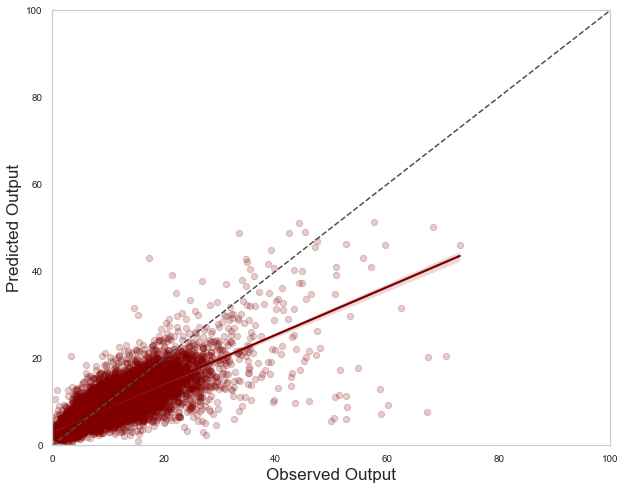

In [117]:
plt.figure(figsize=(10,8))

sns.set(font_scale = 0.9)
sns.set_style("whitegrid", {'axes.grid' : False})

sns.regplot(y_test_pm25, pred_pm25, color = 'maroon',  scatter_kws = {'s':40, 'alpha':0.2})
plt.plot([0, 100], [0, 100], ls="--", c=".3")
plt.xlabel('Observed Output', size= 17)
plt.ylabel('Predicted Output', size= 17)


plt.xlim(0, 100)
plt.ylim(0, 100)

In [ ]:
####### Test Results
### lr = 0.002, r2 = 1.42, rmse = 6.44
### lr = 0.01, r2 = 1.96, rmse = 6.44

In [41]:
val_r2 = 1 - (np.sum(np.square(y_test_pm25 - pred_pm25)) / np.sum(np.square(y_test_pm25 - np.mean(y_test_pm25))))

In [42]:
val_r2

-6345.5568016204725

In [ ]:
def addAtPos(mat1, mat2, xypos):
    """
    Add two matrices of different sizes in place, offset by xy coordinates
    Usage:
      - mat1: base matrix
      - mat2: add this matrix to mat1
      - xypos: tuple (x,y) containing coordinates
    """
    x, y = xypos
    ysize, xsize = mat2.shape
    xmax, ymax = (x + xsize), (y + ysize)
    mat1[y:ymax, x:xmax] += mat2
    return mat1

In [119]:
arr1 = np.array([[1, 2], [3, 4], [5,6]])
arr2 = np.zeros((5,5))

arr1.shape[0]

3

In [ ]:
#### can we remove outliers, PM 2.5 > 40
#### dilute concentration gradient (how? Yang mentioned some steps)
#### because of the mismatch b/w point measurments on the ground and the grid cell, we will underpredict.
#### should mean be used instead of zero padding.
#### 